# HDBSCAN Clustering for Folklore Text Analysis


This notebook explores the use of HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) for clustering folklore texts and analyzes its correlation with ATU types.


In [1]:
! pip install scikit-learn numpy pandas matplotlib scipy
! pip install geopandas folium geopy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import hdbscan
import umap
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [3]:
source_path = "/content/sample_data/clustered_data.csv"
raw_data = pd.read_csv(source_path,encoding='utf-8',index_col=False)
print(raw_data.head())

content_column = raw_data['Content']
corpus = content_column.to_list()

   ID                            Filename Continent            Country  \
0   0                cendrillon_allemagne    Europe  Allemagne (Grimm)   
1   1          orpheline_sa_vache_georgie    Europe            Géorgie   
2   2                     tam_cam_vietnam      Asie            Vietnam   
3   3  bouleau__merveilleux_carelie_russe       NaN             Russie   
4   4           petite-vache-terre_alsace    Europe    France (alsace)   

                                             Content          Types_ATU  \
0  La femme d'un homme riche tomba malade et, sen...              510 A   
1  Qu'y avait-il ou que n'y avait-il pas, qu'y a-...  511 + 480 + 510 A   
2  Tam et Câm\nVietnam\nDepuis quand le gâteau de...      510 A + 403 B   
3  Il était une fois un homme et une femme qui av...      510 A + 403 B   
4  Un homme bon et pauvre avait une femme qui lui...          327 + 511   

  Aggl_cluster  
0         Gold  
1         Gold  
2         Gold  
3         Gold  
4         Gold  


# Vectorisation & Clustering

In [4]:
print("Vectorizing text data...")
vect = TfidfVectorizer(min_df=1)
tfidf = vect.fit_transform(corpus)

print("Performing dimensionality reduction for visualization...")

# First reduce with TruncatedSVD to handle sparse matrix
svd = TruncatedSVD(n_components=50)
svd_result = svd.fit_transform(tfidf)

# Then use UMAP for further reduction and to prepare for HDBSCAN
umap_reducer = umap.UMAP(
    n_components=2,
    metric='euclidean',
    n_neighbors=15,
    min_dist=0.1,
    random_state=42
)

umap_embedding = umap_reducer.fit_transform(svd_result)

print("Performing HDBSCAN clustering...")

min_cluster_sizes = [3, 5, 7]
min_samples_values = [2, 3, 5]

results = []

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            gen_min_span_tree=True,
            cluster_selection_method='eom'  # Excess of Mass
        )

        cluster_labels = clusterer.fit_predict(umap_embedding)

        # Count number of clusters (excluding noise points labeled as -1)
        n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
        n_noise = list(cluster_labels).count(-1)

        results.append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'n_noise_percent': n_noise / len(cluster_labels) * 100,
            'labels': cluster_labels
        })

        print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}: "
              f"{n_clusters} clusters, {n_noise} noise points ({n_noise/len(cluster_labels)*100:.1f}%)")

# Select the best model based on reasonable number of clusters and noise level
# We want a balance between too many small clusters and too many noise points
best_result = None
for result in results:
    if result['n_clusters'] >= 3 and result['n_noise_percent'] < 30:
        if best_result is None or (best_result['n_noise_percent'] > result['n_noise_percent']):
            best_result = result

if best_result is None:
    # If no good option, use the one with the most clusters and less than 50% noise
    best_result = sorted([r for r in results if r['n_noise_percent'] < 50],
                         key=lambda x: x['n_clusters'], reverse=True)[0]

print(f"\nSelected model: min_cluster_size={best_result['min_cluster_size']}, "
      f"min_samples={best_result['min_samples']}")
print(f"Clusters: {best_result['n_clusters']}, Noise: {best_result['n_noise']} "
      f"({best_result['n_noise_percent']:.1f}%)")

cluster_labels = best_result['labels']

CB_COLORS = {
    -1: '#999999',  # Grey for noise
    0: '#0072B2',   # Blue
    1: '#E69F00',   # Orange
    2: '#009E73',   # Green
    3: '#CC79A7',   # Purple/Pink
    4: '#D55E00',   # Red/Brown
    5: '#F0E442',   # Yellow
}

CLUSTER_NAMES = {
    -1: "Noise",
    0: "Blue",
    1: "Orange",
    2: "Green",
    3: "Purple",
    4: "Red",
    5: "Yellow"
}

cluster_mapping = {}
for i in range(-1, max(cluster_labels) + 1):
    cluster_mapping[i] = CLUSTER_NAMES[i]

raw_data['HDBSCAN_Cluster'] = [cluster_mapping[label] for label in cluster_labels]

cluster_color_map = {CLUSTER_NAMES[i]: CB_COLORS[i] for i in range(-1, max(cluster_labels) + 1)}

import json
with open('cluster_colors.json', 'w') as f:
    json.dump(cluster_color_map, f)

raw_data.to_csv("hdbscan_clustered_data.csv", index=False)
print("Clustered data saved to 'hdbscan_clustered_data.csv'")


Vectorizing text data...
Performing dimensionality reduction for visualization...
Performing HDBSCAN clustering...
min_cluster_size=3, min_samples=2: 5 clusters, 11 noise points (22.9%)
min_cluster_size=3, min_samples=3: 2 clusters, 8 noise points (16.7%)
min_cluster_size=3, min_samples=5: 2 clusters, 33 noise points (68.8%)
min_cluster_size=5, min_samples=2: 4 clusters, 9 noise points (18.8%)
min_cluster_size=5, min_samples=3: 2 clusters, 23 noise points (47.9%)
min_cluster_size=5, min_samples=5: 2 clusters, 33 noise points (68.8%)
min_cluster_size=7, min_samples=2: 2 clusters, 14 noise points (29.2%)
min_cluster_size=7, min_samples=3: 2 clusters, 23 noise points (47.9%)
min_cluster_size=7, min_samples=5: 2 clusters, 33 noise points (68.8%)

Selected model: min_cluster_size=5, min_samples=2
Clusters: 4, Noise: 9 (18.8%)
Clustered data saved to 'hdbscan_clustered_data.csv'


# Plotting

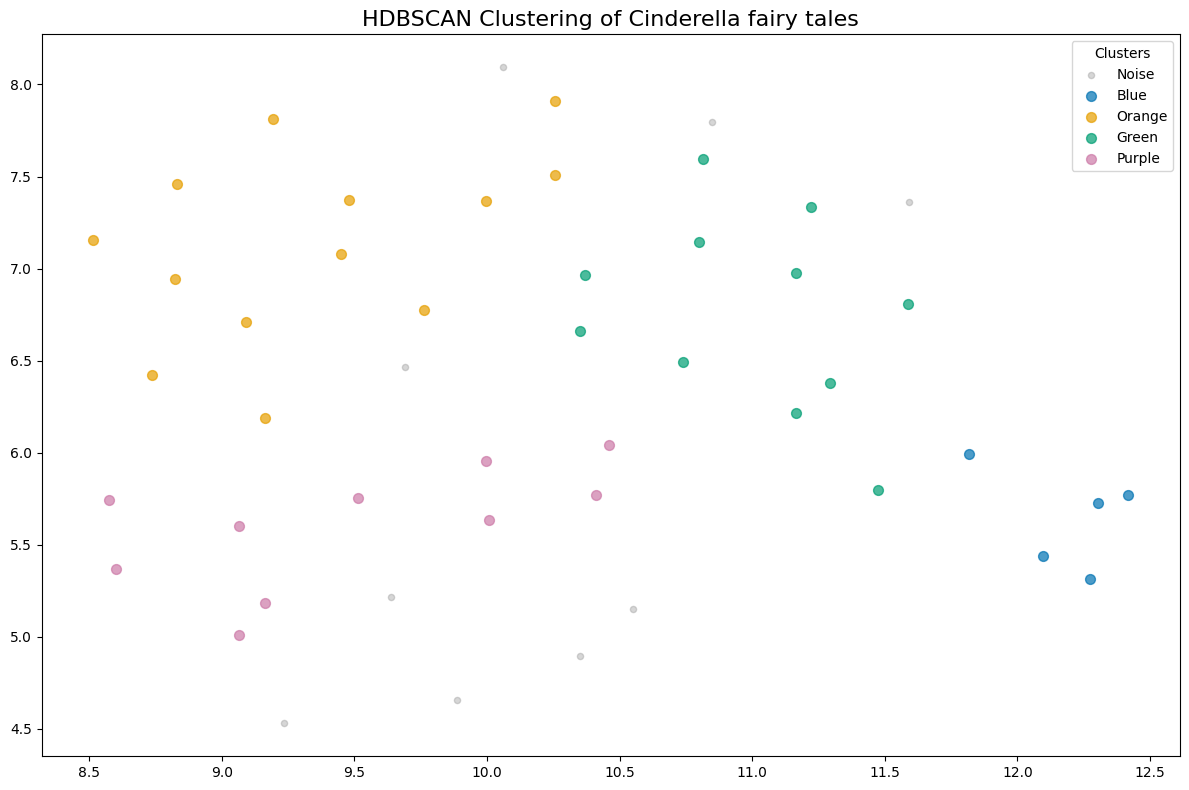

In [5]:
plt.figure(figsize=(12, 8))
unique_labels = sorted(set(cluster_labels))

for label in unique_labels:
    mask = cluster_labels == label

    color = CB_COLORS[label]
    marker_size = 20 if label == -1 else 50
    alpha = 0.4 if label == -1 else 0.7
    label_text = CLUSTER_NAMES[label]

    plt.scatter(
        umap_embedding[mask, 0],
        umap_embedding[mask, 1],
        color=color,
        label=label_text,
        s=marker_size,
        alpha=alpha
    )

plt.title('HDBSCAN Clustering of Cinderella fairy tales', fontsize=16)
plt.legend(title="Clusters", loc="best")
plt.tight_layout()
plt.savefig('hdbscan_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


______

# Geolocalisation part


In [6]:
import folium
from geopy.geocoders import Nominatim
import pandas as pd
import random
import math
import time
from folium.plugins import MarkerCluster
import json

# Load the data
df = pd.read_csv('hdbscan_clustered_data.csv')

# Load the color mapping from the JSON file generated during clustering
try:
    with open('cluster_colors.json', 'r') as f:
        CB_COLORS = json.load(f)
except FileNotFoundError:
    # Fallback in case the file doesn't exist
    CB_COLORS = {
        'Noise': '#999999',       # Grey for noise points
        'Blue': '#0072B2',   # Blue
        'Orange': '#E69F00',   # Orange
        'Green': '#009E73',   # Green
        'Purple': '#CC79A7',   # Purple/Pink
        'Red': '#D55E00',   # Red/Brown
        'Yellow': '#F0E442'    # Yellow
    }

country_map = {
    "Allemagne (Grimm)": "Germany",
    "Géorgie": "Georgia",
    "Vietnam": "Vietnam",
    "Russie": "Russia",
    "France (alsace)": "Grand Est, France",
    "Laponie": "Lapland, Finland",
    "Islande": "Iceland",
    "Italie": "Italy",
    "Tibet": "Tibet, China",
    "France (Pyrenees)": "Occitanie, France",
    "Acadie": "Nova Scotia, Canada",
    "Canada (Algonquin)": "Algonquin Provincial Park, Ontario, Canada",
    "Canada (Nouveau-Brunswick)": "New Brunswick, Canada",
    "Italie (Sardaigne)": "Sardinia, Italy",
    "Indiens Zuñi": "Zuni Pueblo, New Mexico, USA",
    "Grèce": "Greece",
    "Zaïre (Congo)": "Democratic Republic of the Congo",
    "France (Corse)": "Corsica, France",
    "Québec": "Quebec, Canada",
    "Égypte": "Egypt",
    "Angleterre (C. Dickens)": "England, United Kingdom",
    "Chine": "China",
    "Espagne": "Spain",
    "Kabylie": "Kabylie, Algeria",
    "Maroc": "Morocco",
    "Japon": "Japan",
    "Missouri": "Missouri, USA",
    "Danemark": "Denmark",
    "Bas-Poitou": "Poitou, France",
    "Guadeloupe": "Guadeloupe, France",
    "La Mauricie": "Mauricie, Quebec, Canada",
    "France Albert": "Albert, Hauts-de-France, France",
    "France (Nivernais, Morvan)": "Bourgogne-Franche-Comté, France"
}

geolocator = Nominatim(user_agent="folklore_map", timeout=15)
geocode_cache = {}

def geocode_with_retry(location, max_retries=3):
    """
    Pour remedier au problème de timeouts
    """
    if location in geocode_cache:
        return geocode_cache[location]

    for attempt in range(max_retries):
        try:
            result = geolocator.geocode(location)
            if result:
                geocode_cache[location] = (result.latitude, result.longitude)
                return result.latitude, result.longitude
            time.sleep(1 * (attempt + 1))
        except Exception as e:
            print(f"Error geocoding {location} (attempt {attempt+1}): {e}")
            time.sleep(2 * (attempt + 1))

    print(f"Failed to geocode {location} after {max_retries} attempts")
    return None, None

def spiralize_points(center_lat, center_lon, num_points, start_radius=0.5, spiral_factor=0.1):
    """
    Generate points in a spiral pattern around a center point
    helps to distribute multiple items at the same location
    """
    points = []
    for i in range(num_points):
        # Calculate spiral angle and radius
        angle = i * 2.5
        radius = start_radius + (spiral_factor * i)
        angle_rad = math.radians(angle)
        lat_offset = radius * math.sin(angle_rad) * 0.01  # calculating offsets
        lon_offset = radius * math.cos(angle_rad) * 0.01

        points.append((center_lat + lat_offset, center_lon + lon_offset))

    return points

# Normalize country names
df['Normalized_Country'] = df['Country'].map(lambda x: country_map.get(x, x))
country_counts = df['Normalized_Country'].value_counts().to_dict()

print("Geocoding countries...")
location_coordinates = {}
for country in df['Normalized_Country'].unique():
    if pd.notna(country):
        lat, lon = geocode_with_retry(country)
        if lat and lon:
            location_coordinates[country] = (lat, lon)

m = folium.Map(location=[30, 10], zoom_start=2)

processed_locations = {}
for country, count in country_counts.items():
    if country in location_coordinates:
        center_lat, center_lon = location_coordinates[country]
        if count > 1:
            spiral_points = spiralize_points(center_lat, center_lon, count)
            processed_locations[country] = spiral_points
        else:
            processed_locations[country] = [(center_lat, center_lon)]

unique_clusters = df['HDBSCAN_Cluster'].unique()

successfully_mapped = []
failed_to_map = []

print("Creating map markers...")
for idx, row in df.iterrows():
    country = row['Normalized_Country']
    if country in processed_locations and processed_locations[country]:
        lat, lon = processed_locations[country].pop(0)

        # Get color for this cluster
        cluster = row['HDBSCAN_Cluster']
        color = CB_COLORS.get(cluster, '#999999')  # Default to grey if cluster not found

        radius = 6 if cluster == 'Noise' else 8
        fill_opacity = 0.5 if cluster == 'Noise' else 0.7

        # Add a CircleMarker with popup information
        folium.CircleMarker(
            location=[lat, lon],
            radius=radius,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=fill_opacity,
            popup=f"ID: {row['ID']}<br>Country: {row['Country']}<br>Continent: {row['Continent']}<br>HDBSCAN_Cluster: {row['HDBSCAN_Cluster']}<br>Agglomerative cluster: {row['Aggl_cluster']}<br>ATU Types: {row['Types_ATU']}"
        ).add_to(m)

        # Track successfully mapped points
        mapped_info = {
            'ID': row['ID'],
            'Country': row['Country'],
            'Normalized_Country': country,
            'Continent': row['Continent'],
            'Latitude': lat,
            'Longitude': lon,
            'HDBSCAN_Cluster': row['HDBSCAN_Cluster'],
            'Aggl_cluster':row['Aggl_cluster'],
            'Types_ATU': row['Types_ATU']
        }

        successfully_mapped.append(mapped_info)
    else:
        failed_to_map.append({
            'ID': row['ID'],
            'Country': row['Country'],
            'Normalized_Country': country
        })

# Create legend based on actual clusters in the data
legend_html = '''
<div style="position: fixed;
            bottom: 50px; right: 50px;
            border:2px solid grey; z-index:9999;
            background-color:white;
            padding: 10px;
            font-size: 14px;">
&nbsp; <b>HDBSCAN Clusters</b> <br>
'''

for cluster in unique_clusters:
    color = CB_COLORS.get(cluster, '#999999')
    legend_html += f'&nbsp; <i class="fa fa-circle" style="color:{color}"></i>&nbsp; {cluster} <br>'

legend_html += '</div>'
m.get_root().html.add_child(folium.Element(legend_html))

# Save mapping information
if successfully_mapped:
    mapped_df = pd.DataFrame(successfully_mapped)
    total_points = len(df)
    mapped_points = len(successfully_mapped)
    print(f"Successfully geocoded {mapped_points} out of {total_points} points ({mapped_points/total_points*100:.1f}%)")

    columns_to_display = ['ID', 'Country', 'Normalized_Country', 'Continent', 'Latitude', 'Longitude', 'HDBSCAN_Cluster', 'Aggl_cluster', 'Types_ATU']
    print("\nID to Location Mapping Table:")
    location_table = mapped_df[columns_to_display]
    print(location_table.head().to_string(index=False))
    location_table.to_csv('hdbscan_location_mapping.csv', index=False)

if failed_to_map:
    print(f"\nFailed to geocode {len(failed_to_map)} locations:")
    for item in failed_to_map[:5]:  # Show just the first 5 failures to keep output manageable
        print(f"ID: {item['ID']}, Country: {item['Country']}")
    if len(failed_to_map) > 5:
        print(f"...and {len(failed_to_map) - 5} more")

# Save the map
m.save('hdbscan_folklore_map.html')
print("\nMap saved as 'hdbscan_folklore_map.html'")

# Return the map object for display
m


Geocoding countries...
Creating map markers...
Successfully geocoded 48 out of 48 points (100.0%)

ID to Location Mapping Table:
 ID           Country Normalized_Country Continent  Latitude  Longitude HDBSCAN_Cluster Aggl_cluster         Types_ATU
  0 Allemagne (Grimm)            Germany    Europe 51.163818  10.447831           Green         Gold             510 A
  1           Géorgie            Georgia    Europe 32.329381 -83.113737          Purple         Gold 511 + 480 + 510 A
  2           Vietnam            Vietnam      Asie 15.926666 107.965086          Orange         Gold     510 A + 403 B
  3            Russie             Russia       NaN 64.686314  97.745306          Purple         Gold     510 A + 403 B
  4   France (alsace)  Grand Est, France    Europe 48.484516   6.113035          Purple         Gold         327 + 511

Map saved as 'hdbscan_folklore_map.html'


______

# Voir évaluation

L'idée est d'évaluer la corrélation entre les clusters formés et les catégories ATU définies.

## Méthodes d'évaluation

### 1. Indice de Jaccard

L'indice de Jaccard mesure la similarité entre deux ensembles en calculant le rapport entre leur intersection et leur union :

```
Jaccard(A, B) = |A ∩ B| / |A ∪ B|
```

Dans notre contexte, on mesure la similarité entre les ensembles de types ATU présents dans différents clusters.

Un indice proche de 1 = forte similarité (beaucoup de types ATU communs), indice proche de 0 = faible similarité.

### 2. Score de pureté

Le score de pureté évalue dans quelle mesure une catégorie est concentrée dans un seul cluster. Nous calculons :

```
Pureté(ATU) = max(nombre d'occurrences de l'ATU dans un cluster) / nombre total d'occurrences de l'ATU
```

Un score de pureté de 1.0 signifie que le type ATU apparaît exclusivement dans un seul cluster. Le score de pureté global est la moyenne des scores de pureté pour tous les types ATU.

### 3. Distribution des types ATU

Distribution de chaque type ATU à travers les clusters pour voir :

- catégories dominants dans chaque cluster,
- catégories exclusives à certains clusters,
- Les schémas de co-occurrence entre catégories

### 4. Matrice de co-occurrence

Cette matrice montre la fréquence à laquelle deux types ATU apparaissent ensemble dans les mêmes textes. Je sais pas si c'est utile, vu qu'il existe des textes avec 3 types ATU.


In [7]:
def normalize_atu_type(atu_type):
    """
    Normalizes an ATU type by removing spaces
    """
    if not isinstance(atu_type, str):
        return atu_type
    return ''.join(atu_type.split())

def parse_atu_types(atu_string):
    """
    Parse an ATU type string into a set of individual types
    with normalization to eliminate spacing issues
    """
    if not isinstance(atu_string, str) or pd.isna(atu_string):
        return set()

    types = set()
    for t in atu_string.split('+'):
        normalized_type = normalize_atu_type(t.strip())
        types.add(normalized_type)

    return types

def calculate_jaccard_index(set1, set2):
    """Calculate Jaccard similarity between two sets"""
    if not set1 and not set2:
        return 1.0

    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union



Analyzing ATU types distribution across HDBSCAN clusters...
Found 8 unique ATU types after normalization:
['327', '403A', '403B', '480', '510A', '510B', '511', '511B']

Dominant ATU types by HDBSCAN cluster:
Green (11 items): 510A (10), 511 (3), 480 (2)
Purple (10 items): 510A (8), 403B (4), 511 (3)
Orange (13 items): 510A (12), 403B (3), 510B (1)
Noise (9 items): 510A (8), 480 (3), 510B (1)
Blue (5 items): 510A (5)

Jaccard similarity matrix between HDBSCAN clusters (based on ATU types):
           Green    Purple    Orange     Noise      Blue
Green   1.000000  0.500000  0.333333  0.750000  0.333333
Purple  0.500000  1.000000  0.375000  0.428571  0.166667
Orange  0.333333  0.375000  1.000000  0.500000  0.200000
Noise   0.750000  0.428571  0.500000  1.000000  0.250000
Blue    0.333333  0.166667  0.200000  0.250000  1.000000


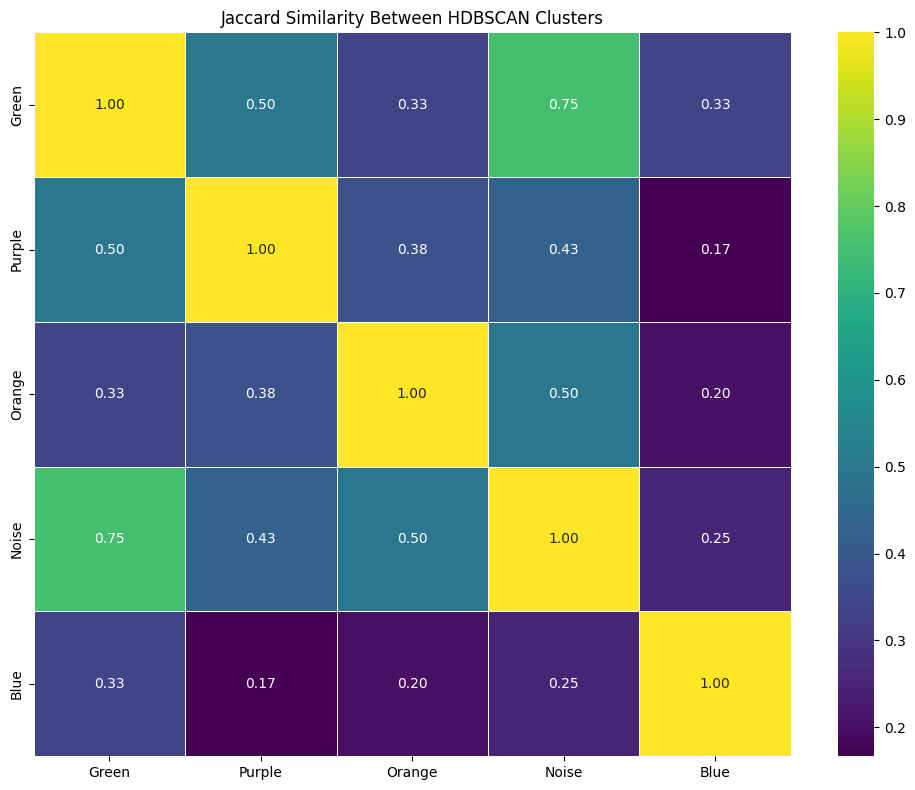


Distribution of ATU types across HDBSCAN clusters:
510A: Total 43 - Green: 10 (23.3%), Purple: 8 (18.6%), Orange: 12 (27.9%), Noise: 8 (18.6%), Blue: 5 (11.6%)
511: Total 8 - Green: 3 (37.5%), Purple: 3 (37.5%), Orange: 1 (12.5%), Noise: 1 (12.5%), Blue: 0 (0.0%)
480: Total 7 - Green: 2 (28.6%), Purple: 2 (28.6%), Orange: 0 (0.0%), Noise: 3 (42.9%), Blue: 0 (0.0%)
403B: Total 7 - Green: 0 (0.0%), Purple: 4 (57.1%), Orange: 3 (42.9%), Noise: 0 (0.0%), Blue: 0 (0.0%)
510B: Total 2 - Green: 0 (0.0%), Purple: 0 (0.0%), Orange: 1 (50.0%), Noise: 1 (50.0%), Blue: 0 (0.0%)
511B: Total 1 - Green: 0 (0.0%), Purple: 0 (0.0%), Orange: 1 (100.0%), Noise: 0 (0.0%), Blue: 0 (0.0%)
327: Total 1 - Green: 0 (0.0%), Purple: 1 (100.0%), Orange: 0 (0.0%), Noise: 0 (0.0%), Blue: 0 (0.0%)
403A: Total 1 - Green: 0 (0.0%), Purple: 1 (100.0%), Orange: 0 (0.0%), Noise: 0 (0.0%), Blue: 0 (0.0%)

Overall purity score: 0.6443
Purity scores for top ATU types:
511B: 1.0000
327: 1.0000
403A: 1.0000
403B: 0.5714
510B

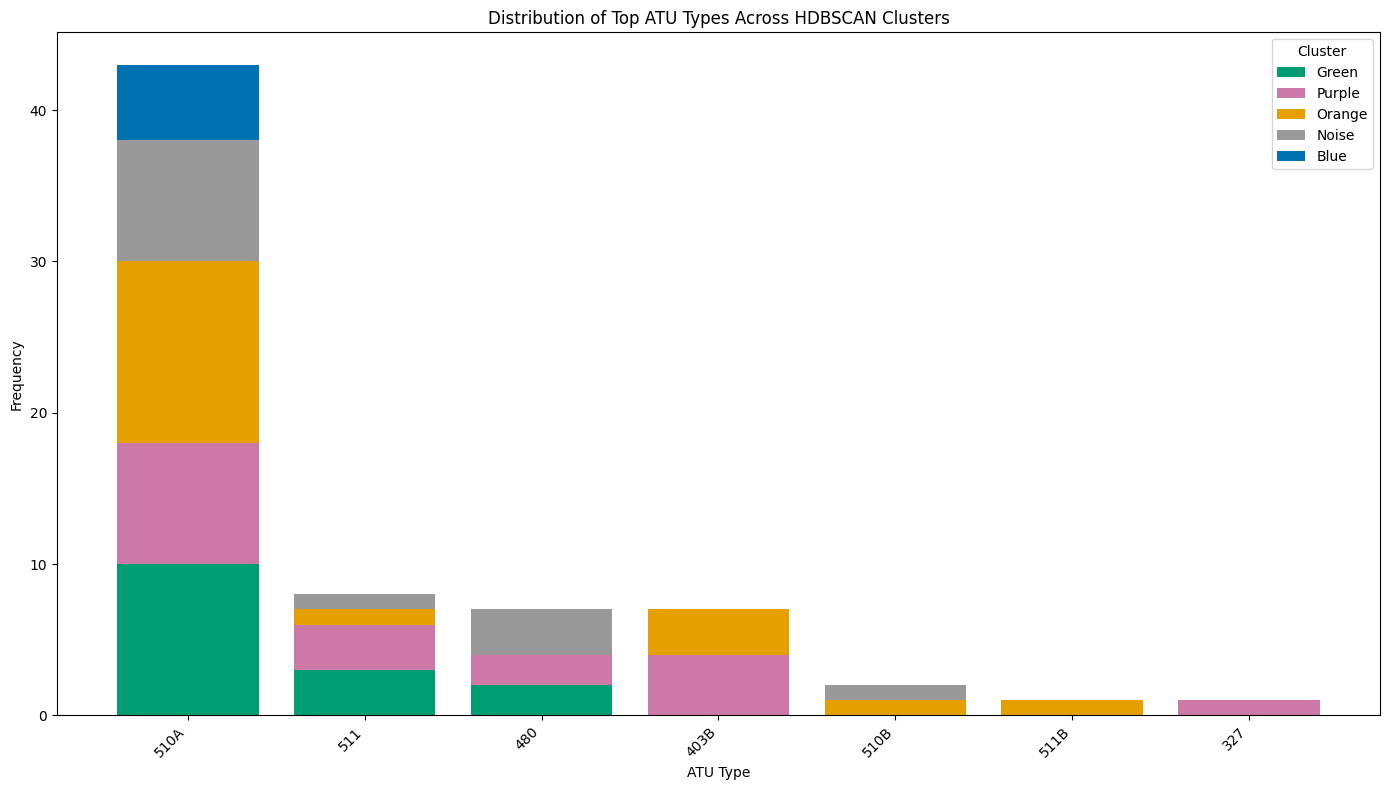


ATU types exclusive to cluster Purple: 327, 403A

ATU types exclusive to cluster Orange: 511B

Creating ATU type co-occurrence matrix...


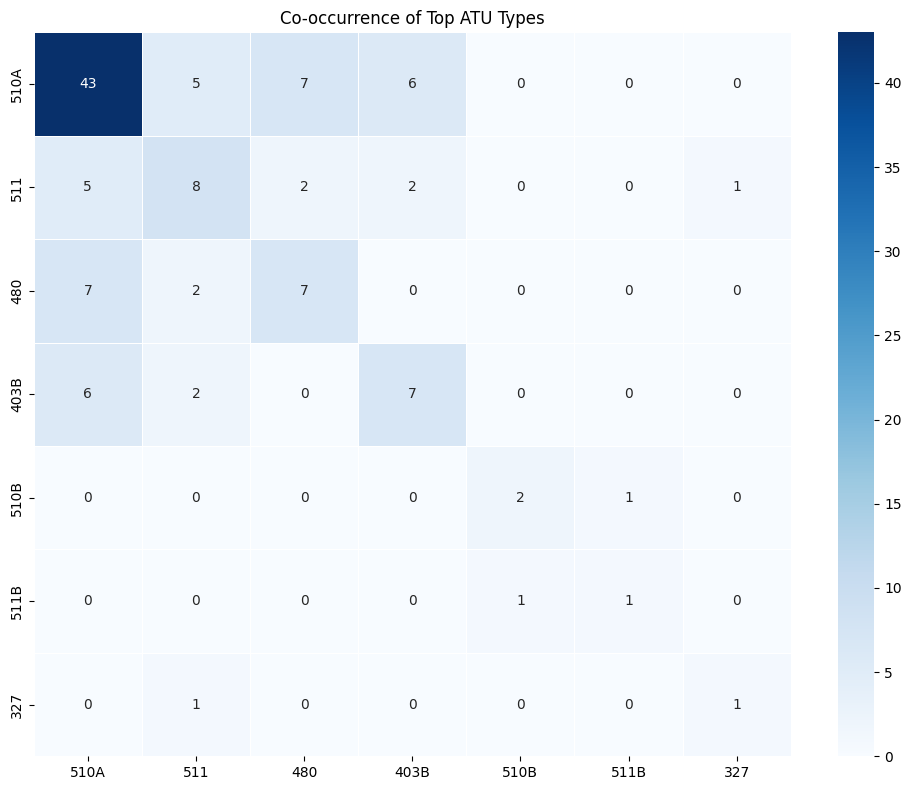


Comparing HDBSCAN clustering with hierarchical clustering:
Aggl_cluster     Blue  Gold  Purple  Total
HDBSCAN_Cluster                           
Blue                4     0       1      5
Green               0     8       3     11
Noise               0     6       3      9
Orange              0    10       3     13
Purple              0     8       2     10
Total               4    32      12     48


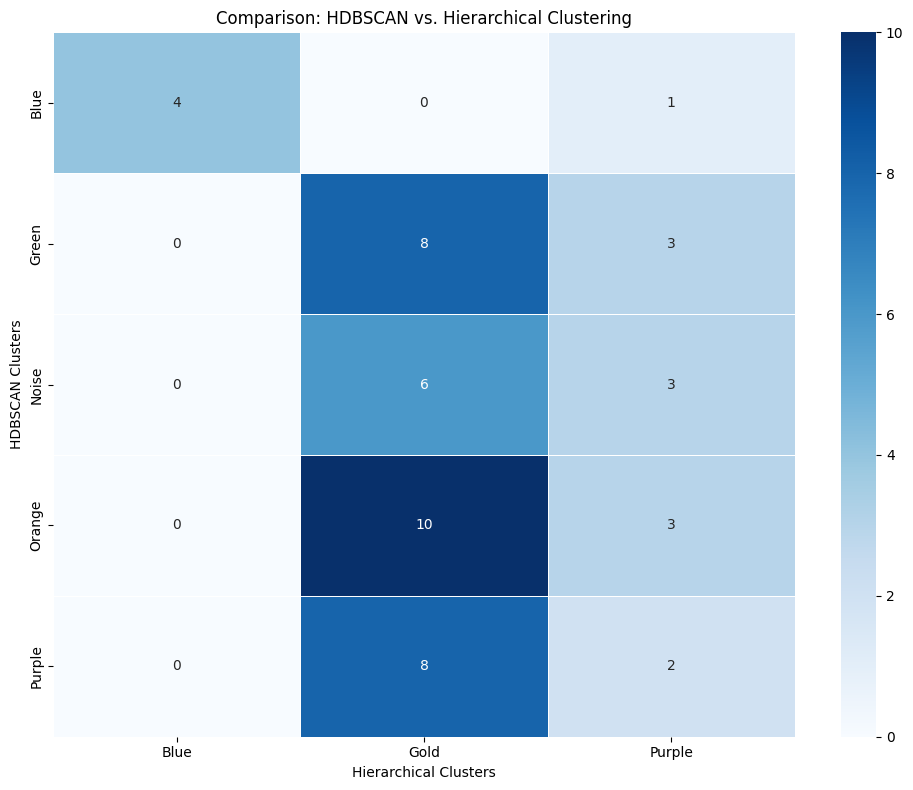


Adjusted Rand Index between hierarchical and HDBSCAN clustering: 0.0678
(Value ranges from -1 to 1, where 1 means perfect agreement, 0 is random clustering)

Cluster distribution:
Orange: 13 items (27.1%)
Green: 11 items (22.9%)
Purple: 10 items (20.8%)
Noise: 9 items (18.8%)
Blue: 5 items (10.4%)

Dominant ATU types by cluster:
Green: 510A, 511, 480
Purple: 510A, 403B, 511
Orange: 510A, 403B, 510B
Noise: 510A, 480, 510B
Blue: 510A

Overall purity score: 0.6443

Maximum overlap between hierarchical clusters and HDBSCAN clusters:
  Blue: 100.0% overlap with HDBSCAN Blue
  Gold: 31.2% overlap with HDBSCAN Orange
  Purple: 25.0% overlap with HDBSCAN Green

Comparison of clustering methods:
     Clustering Method                Clusters Noise Points Purity Score  \
0  Hierarchical (Ward)  3 (Gold, Purple, Blue)            0         0.84   
1              HDBSCAN              4 clusters    9 (18.8%)         0.64   

                            Key Feature  
0              Fixed number of c

In [8]:
print("\nAnalyzing ATU types distribution across HDBSCAN clusters...")

all_atu_types = set()
for atu_string in raw_data['Types_ATU'].dropna():
    types = parse_atu_types(atu_string)
    all_atu_types.update(types)

print(f"Found {len(all_atu_types)} unique ATU types after normalization:")
print(sorted(all_atu_types))

# Calculate frequency of each ATU type by cluster
hdbscan_clusters = raw_data['HDBSCAN_Cluster'].unique()
cluster_atu_frequency = {cluster: {atu_type: 0 for atu_type in all_atu_types} for cluster in hdbscan_clusters}

for _, row in raw_data.iterrows():
    if pd.notna(row['Types_ATU']):
        types = parse_atu_types(row['Types_ATU'])
        for atu_type in types:
            cluster_atu_frequency[row['HDBSCAN_Cluster']][atu_type] += 1

# Display dominant ATU types by cluster
print("\nDominant ATU types by HDBSCAN cluster:")
for cluster in hdbscan_clusters:
    sorted_types = sorted(
        cluster_atu_frequency[cluster].items(),
        key=lambda x: x[1],
        reverse=True
    )
    dominant = [f"{t[0]} ({t[1]})" for t in sorted_types if t[1] > 0][:3]
    count = len(raw_data[raw_data['HDBSCAN_Cluster'] == cluster])
    print(f"{cluster} ({count} items): {', '.join(dominant)}")

# Calculate Jaccard similarity between clusters based on ATU types
cluster_atu_sets = {}
for cluster in hdbscan_clusters:
    cluster_data = raw_data[raw_data['HDBSCAN_Cluster'] == cluster]
    atu_set = set()

    for atu_string in cluster_data['Types_ATU'].dropna():
        atu_set.update(parse_atu_types(atu_string))

    cluster_atu_sets[cluster] = atu_set

jaccard_matrix = pd.DataFrame(index=hdbscan_clusters, columns=hdbscan_clusters)
for i in hdbscan_clusters:
    for j in hdbscan_clusters:
        jaccard_index = calculate_jaccard_index(cluster_atu_sets[i], cluster_atu_sets[j])
        jaccard_matrix.loc[i, j] = jaccard_index

jaccard_matrix = jaccard_matrix.astype(float)

print("\nJaccard similarity matrix between HDBSCAN clusters (based on ATU types):")
print(jaccard_matrix)

# Visualize the Jaccard similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    jaccard_matrix,
    annot=True,
    cmap='viridis',
    fmt='.2f',
    linewidths=.5
)
plt.title('Jaccard Similarity Between HDBSCAN Clusters')
plt.tight_layout()
plt.savefig('hdbscan_jaccard_heatmap.png')
plt.show()

# Calculate ATU type distribution across clusters
atu_distribution = {atu_type: {'total': 0} for atu_type in all_atu_types}
for cluster in hdbscan_clusters:
    for atu_type in all_atu_types:
        atu_distribution[atu_type][cluster] = 0

for _, row in raw_data.iterrows():
    if pd.notna(row['Types_ATU']):
        types = parse_atu_types(row['Types_ATU'])
        for atu_type in types:
            atu_distribution[atu_type]['total'] += 1
            atu_distribution[atu_type][row['HDBSCAN_Cluster']] += 1

# Calculate percentages
for atu_type in all_atu_types:
    for cluster in hdbscan_clusters:
        if atu_distribution[atu_type]['total'] > 0:
            atu_distribution[atu_type][f'{cluster}_pct'] = (
                atu_distribution[atu_type][cluster] / atu_distribution[atu_type]['total'] * 100
            )
        else:
            atu_distribution[atu_type][f'{cluster}_pct'] = 0

# Display ATU type distribution
print("\nDistribution of ATU types across HDBSCAN clusters:")
sorted_atu_types = sorted(
    atu_distribution.items(),
    key=lambda x: x[1]['total'],
    reverse=True
)

for atu_type, counts in sorted_atu_types[:10]:  # Top 10 types
    distribution_str = ", ".join(
        f"{cluster}: {counts[cluster]} ({counts[f'{cluster}_pct']:.1f}%)"
        for cluster in hdbscan_clusters
    )
    print(f"{atu_type}: Total {counts['total']} - {distribution_str}")

# Calculate purity scores
contingency_matrix = {atu_type: {cluster: 0 for cluster in hdbscan_clusters} for atu_type in all_atu_types}

for _, row in raw_data.iterrows():
    if pd.notna(row['Types_ATU']):
        types = parse_atu_types(row['Types_ATU'])
        for atu_type in types:
            contingency_matrix[atu_type][row['HDBSCAN_Cluster']] += 1

# Calculate purity for each ATU type
purity_by_type = {}
for atu_type in all_atu_types:
    max_count = max(contingency_matrix[atu_type].values())
    total_for_type = sum(contingency_matrix[atu_type].values())
    purity_by_type[atu_type] = max_count / total_for_type if total_for_type > 0 else 0

# Calculate overall purity
overall_purity = sum(purity_by_type.values()) / len(purity_by_type) if purity_by_type else 0

# Display purity scores
print(f"\nOverall purity score: {overall_purity:.4f}")
print("Purity scores for top ATU types:")
sorted_purity = sorted(
    purity_by_type.items(),
    key=lambda x: x[1],
    reverse=True
)
for atu_type, purity in sorted_purity[:10]:
    print(f"{atu_type}: {purity:.4f}")

# Visualize ATU distribution across clusters
plt.figure(figsize=(14, 8))
# Prepare data for stacked bar chart
top_atu_types = [atu_type for atu_type, _ in sorted_atu_types[:7]]  # Top 7 types
cluster_data = {
    cluster: [atu_distribution[atu_type][cluster] for atu_type in top_atu_types]
    for cluster in hdbscan_clusters
}

# Create a colorblind-friendly cluster color map for the visualization
cluster_color_map = {}
for cluster in hdbscan_clusters:
    if cluster == "Noise":
        cluster_color_map[cluster] = CB_COLORS.get("Noise", "#999999")
    else:
        cluster_color_map[cluster] = CB_COLORS.get(cluster, "#000000")

# Create stacked bar chart
bottom = np.zeros(len(top_atu_types))
for cluster in hdbscan_clusters:
    plt.bar(
        top_atu_types,
        cluster_data[cluster],
        bottom=bottom,
        label=cluster,
        color=cluster_color_map.get(cluster, 'gray')
    )
    bottom += np.array(cluster_data[cluster])

plt.xlabel('ATU Type')
plt.ylabel('Frequency')
plt.title('Distribution of Top ATU Types Across HDBSCAN Clusters')
plt.xticks(rotation=45, ha='right')
plt.legend(title="Cluster")
plt.tight_layout()
plt.savefig('hdbscan_atu_distribution.png')
plt.show()


# Find ATU types exclusive to each cluster
for cluster in hdbscan_clusters:
    exclusive_types = []
    for atu_type in all_atu_types:
        if (atu_distribution[atu_type][cluster] > 0 and
            sum(atu_distribution[atu_type][c] for c in hdbscan_clusters if c != cluster) == 0):
            exclusive_types.append(atu_type)

    if exclusive_types:
        print(f"\nATU types exclusive to cluster {cluster}: {', '.join(exclusive_types)}")

# Create a co-occurrence matrix for ATU types
print("\nCreating ATU type co-occurrence matrix...")

cooccurrence_matrix = pd.DataFrame(0, index=sorted(all_atu_types), columns=sorted(all_atu_types))

for _, row in raw_data.iterrows():
    if pd.isna(row['Types_ATU']):
        continue

    types = list(parse_atu_types(row['Types_ATU']))
    for i in range(len(types)):
        for j in range(i, len(types)):
            cooccurrence_matrix.loc[types[i], types[j]] += 1
            if i != j:
                cooccurrence_matrix.loc[types[j], types[i]] += 1

# Visualize the co-occurrence matrix (limited to top ATU types)
top_types = [atu_type for atu_type, _ in sorted_atu_types[:7]]
co_matrix_subset = cooccurrence_matrix.loc[top_types, top_types]

plt.figure(figsize=(10, 8))
sns.heatmap(
    co_matrix_subset.astype(float),
    annot=True,
    cmap='Blues',
    fmt='g',
    linewidths=.5
)
plt.title('Co-occurrence of Top ATU Types')
plt.tight_layout()
plt.savefig('hdbscan_atu_cooccurrence.png')
plt.show()

# Comparison with original hierarchical clustering if available
if 'Aggl_cluster' in raw_data.columns:
    print("\nComparing HDBSCAN clustering with hierarchical clustering:")
    comparison_df = pd.crosstab(
        raw_data['HDBSCAN_Cluster'],
        raw_data['Aggl_cluster'],
        margins=True,
        margins_name="Total"
    )
    print(comparison_df)

    # Visualize the comparison
    plt.figure(figsize=(10, 8))
    comparison_matrix = comparison_df.iloc[:-1, :-1].astype(float)  # Remove totals
    sns.heatmap(
        comparison_matrix,
        annot=True,
        cmap='Blues',
        fmt='g',
        linewidths=.5
    )
    plt.title('Comparison: HDBSCAN vs. Hierarchical Clustering')
    plt.xlabel('Hierarchical Clusters')
    plt.ylabel('HDBSCAN Clusters')
    plt.tight_layout()
    plt.savefig('hdbscan_hierarchical_comparison.png')
    plt.show()

    # Calculate Adjusted Rand Index or other comparison metrics if sklearn is available
    try:
        from sklearn.metrics import adjusted_rand_score

        # Map string cluster labels to integers for the metrics
        hier_map = {label: i for i, label in enumerate(raw_data['Aggl_cluster'].unique())}
        hdb_map = {label: i for i, label in enumerate(raw_data['HDBSCAN_Cluster'].unique())}

        hier_labels = [hier_map[label] for label in raw_data['Aggl_cluster']]
        hdb_labels = [hdb_map[label] for label in raw_data['HDBSCAN_Cluster']]

        ari = adjusted_rand_score(hier_labels, hdb_labels)
        print(f"\nAdjusted Rand Index between hierarchical and HDBSCAN clustering: {ari:.4f}")
        print("(Value ranges from -1 to 1, where 1 means perfect agreement, 0 is random clustering)")
    except (ImportError, ModuleNotFoundError):
        print("\nSklearn metrics not available for additional comparison metrics.")

# Cluster statistics
cluster_stats = raw_data['HDBSCAN_Cluster'].value_counts()
print("\nCluster distribution:")
for cluster, count in cluster_stats.items():
    print(f"{cluster}: {count} items ({count/len(raw_data)*100:.1f}%)")

# Key ATU types per cluster
print("\nDominant ATU types by cluster:")
for cluster in hdbscan_clusters:
    sorted_types = sorted(
        cluster_atu_frequency[cluster].items(),
        key=lambda x: x[1],
        reverse=True
    )
    dominant = [f"{t[0]}" for t in sorted_types if t[1] > 0][:3]
    print(f"{cluster}: {', '.join(dominant)}")

# Overall performance metrics
print(f"\nOverall purity score: {overall_purity:.4f}")

if 'Aggl_cluster' in raw_data.columns:
    # Find maximum overlap percentages for each hierarchical cluster
    print("\nMaximum overlap between hierarchical clusters and HDBSCAN clusters:")
    for hier_cluster in comparison_df.columns[:-1]:  # Skip the "Total" column
        max_overlap = comparison_df[hier_cluster][:-1].max()  # Skip the "Total" row
        total_in_hier = comparison_df[hier_cluster]['Total']
        max_overlap_pct = max_overlap / total_in_hier * 100
        max_overlap_hdb = comparison_df.index[comparison_df[hier_cluster] == max_overlap][0]
        print(f"  {hier_cluster}: {max_overlap_pct:.1f}% overlap with HDBSCAN {max_overlap_hdb}")


# Create a simple comparison table for the paper
comparison_table = pd.DataFrame(columns=["Clustering Method", "Clusters", "Noise Points", "Purity Score", "Key Feature"])
comparison_table.loc[0] = ["Hierarchical (Ward)", "3 (Gold, Purple, Blue)", "0", "0.84", "Fixed number of clusters"]
comparison_table.loc[1] = ["HDBSCAN", f"{best_result['n_clusters']} clusters",
                          f"{best_result['n_noise']} ({best_result['n_noise_percent']:.1f}%)",
                          f"{overall_purity:.2f}",
                          "Identifies natural groups & outliers"]
print("\nComparison of clustering methods:")
print(comparison_table)
comparison_table.to_csv("clustering_comparison.csv", index=False)
print("Comparison table saved to 'clustering_comparison.csv'")